In [100]:
import os
import numpy as np
import pandas as pd

from astropy import units as u
from astropy.table import Table, Column, MaskedColumn
from astropy.time import Time, TimeDelta
from astropy.coordinates import SkyCoord, Distance, GCRS, CartesianRepresentation, match_coordinates_sky
from astropy.wcs import WCS
from astropy.io import fits, ascii
from astroquery.vizier import Vizier
import itertools

from collections import Counter
import matplotlib.pyplot as plt

import pickle

### 函数定义

In [101]:
def work_sext(
    image_path: str,
    config_path: str,
    out_path: str,
    flag_path: str,
    weight_path: str,
    out_para_path: str,
    filter_path: str,
):
    """
    Do astrometry by source-extractor.

    Do astrometry by source-extractor, the basic use of source-extractor is 'source-extractor  -c ' + fp_config + fp_image'

    Parameters
    ----------
    image_path : str
        The image fits to be processed, *.fits.
    config_path : str
        The config file of source-extractor, *.sex.
    out_path : str
        The name of the output catalog.
    out_para_path : str
        The parameters of the output catalog, *.param.
    filter_path : str
        The filter of the image, *.conv.

    Returns
    -------
    None

    Examples
    -------
    >>> work_sext(fp_img,fp_config_sext,fp_out_sext,fp_para_sext,fp_filter_sext)
    """
    fp_image = image_path
    fp_config = config_path
    fp_out = out_path
    fp_flg = flag_path
    fp_wht = weight_path
    fp_para = out_para_path
    fp_filter = filter_path

    cmd_sex = (
        "sex -c "
        + fp_config + " "
        + fp_image
        + " -CATALOG_NAME "
        + fp_out
        + " -FLAG_IMAGE "
        + fp_flg
        + " -WEIGHT_IMAGE "
        + fp_wht
        + " -PARAMETERS_NAME "
        + fp_para
        + " -FILTER_NAME "
        + fp_filter
    )

    os.system(cmd_sex)

def gaiadr3_query(
    ra: list,
    dec: list,
    rad: float = 1.0,
    maxmag: float = 25,
    maxsources: float = 1000000,
):
    """
    Acquire the Gaia DR3.

    This function uses astroquery.vizier to query Gaia DR3 catalog.

    Parameters
    ----------
    ra : list
        RA of center in degrees.
    dec : list
        Dec of center in degrees.
    rad : float
        Field radius in degrees.
    maxmag : float
        Upper limit magnitude.
    maxsources : float
        Maximum number of sources.

    Returns
    -------
    Table
        table of reference catalog.

    Examples
    --------
    >>> catalog = gaiadr3_query(ra, dec, rad, maxmag, maxsources)
    """

    vquery = Vizier(
        columns=["RA_ICRS", "DE_ICRS", "pmRA", "pmDE", "Plx", "RVDR2", "Gmag", "RV"],
        row_limit=maxsources,
        column_filters={"Gmag": ("<%f" % maxmag), "Plx": ">0"},
    )
    coord = SkyCoord(ra=ra, dec=dec, unit=u.deg, frame="icrs")
    r = vquery.query_region(coord, radius=rad * u.deg, catalog="I/355/gaiadr3")

    return r[0]

def ideal_cel_coord(xi, eta, ra_c, dec_c):
    ra_c = np.deg2rad(ra_c)
    dec_c = np.deg2rad(dec_c)

    ra = np.arctan(xi / (np.cos(dec_c) - eta * np.sin(dec_c))) + ra_c
    dec = np.arctan(
        (eta * np.cos(dec_c) + np.sin(dec_c))
        / (np.cos(dec_c) - eta * np.sin(dec_c))
        * np.cos(ra - ra_c)
    )
    ra = np.degrees(ra)
    dec = np.degrees(dec)

    return ra, dec

def cel_ideal_coord(ra, dec, ra_c, dec_c):

    ra = np.radians(ra)
    dec = np.radians(dec)
    ra_c = np.radians(ra_c)
    dec_c = np.radians(dec_c)

    xi = (np.cos(dec) * np.sin(ra - ra_c)) / (
        np.sin(dec_c) * np.sin(dec) + np.cos(dec_c) * np.cos(dec) * np.cos(ra - ra_c)
    )
    eta = (
        np.cos(dec_c) * np.sin(dec) - np.sin(dec_c) * np.cos(dec) * np.cos(ra - ra_c)
    ) / (np.sin(dec_c) * np.sin(dec) + np.cos(dec_c) * np.cos(dec) * np.cos(ra - ra_c))

    return xi, eta

def pos_side(ra_a, dec_a, ra_b, dec_b):
    ra_a_c = np.deg2rad(ra_a)
    dec_a_c = np.deg2rad(dec_a)
    ra_b_c = np.deg2rad(ra_b)
    dec_b_c = np.deg2rad(dec_b)

    a_vector = np.array([np.cos(dec_a_c) * np.cos(ra_a_c), np.cos(dec_a_c) * np.sin(ra_a_c), np.sin(dec_a_c)])
    b_vector = np.array([np.cos(dec_b_c) * np.cos(ra_b_c), np.cos(dec_b_c) * np.sin(ra_b_c), np.sin(dec_b_c)])
    return np.rad2deg(np.arccos(np.sum(a_vector * b_vector, axis=0)))


def cal_plate_model(X_x, X_y, Y_xi, Y_eta, cof):
    
    X_xy = []
    for i in range(0, cof + 1):
        for j in range(0, i + 1):
            X_xy.append(X_x ** (i - j) * X_y ** j)
    X_xy = np.array(X_xy).T
    
    A_CD1 = np.linalg.inv(X_xy.T @ X_xy) @ X_xy.T @ Y_xi
    A_CD2 = np.linalg.inv(X_xy.T @ X_xy) @ X_xy.T @ Y_eta

    A_CD = np.array([A_CD1, A_CD2])

    return A_CD

def use_plate_model(X_x, X_y, A_CD, cof):

    X_xy = []
    for i in range(0, cof + 1):
        for j in range(0, i + 1):
            X_xy.append(X_x ** (i - j) * X_y ** j)
    X_xy = np.array(X_xy).T

    xi_eta = A_CD @ X_xy.T * (np.pi / 180)

    return xi_eta

# def cal_plate_model(X_x, X_y, Y_xi, Y_eta):
#     # X_xy = np.array([np.ones_like(X_x), X_x, X_y, X_x ** 2, X_x * X_y, X_y ** 2, 
#     #              X_x ** 3, X_x ** 2 * X_y, X_x * X_y ** 2, X_y ** 3]).T
#     # X_xy = np.array([np.ones_like(X_x), X_x, X_y, X_x ** 2, X_x * X_y, X_y ** 2]).T
#     X_xy = np.array([np.ones_like(X_x), X_x, X_y, X_x ** 2, X_x * X_y, X_y ** 2]).T
    
#     A_CD1 = np.linalg.inv(X_xy.T @ X_xy) @ X_xy.T @ Y_xi

#     A_CD2 = np.linalg.inv(X_xy.T @ X_xy) @ X_xy.T @ Y_eta

#     A_CD = np.array([A_CD1, A_CD2])

#     return A_CD

# def use_plate_model(X_x, X_y, A_CD):
#     # X_xy = np.array([np.ones_like(X_x), X_x, X_y, X_x ** 2, X_x * X_y, X_y ** 2, 
#     #              X_x ** 3, X_x ** 2 * X_y, X_x * X_y ** 2, X_y ** 3]).T
#     X_xy = np.array([np.ones_like(X_x), X_x, X_y, X_x ** 2, X_x * X_y, X_y ** 2]).T
#     xi_eta = A_CD @ X_xy.T * (np.pi / 180)

#     return xi_eta

def write_ds9_region(filename, data, str_x, str_y):

    with open(filename, "w") as f:
        f.write(
            'global color=red dashlist=8 3 width=1 font="helvetica 10 normal roman" '
            "select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1"
            + "\n"
        )
        f.write("physical" + "\n")
        for i in range(len(data)):
            f.write(
                "circle("
                + str("%12.6f" % (data[str_x][i]))
                + ",  "
                + str("%12.6f" % (9232 - data[str_y][i]))
                + ","
                + str(15)
                + ")"
                + "\n"
            )

def match_box_id(points_x, points_y, bins_x, bins_y):
    # bins_x_id and bins_y_id
    bins_x_id = np.digitize(points_x, bins_x) - 1
    bins_y_id = np.digitize(points_y, bins_y) - 1

    return bins_x_id, bins_y_id


def cal_distort_model(dis_res_xy_list, bins_x, bins_y, bins_num, distort_sum_bins, distort_sum_values_x, distort_sum_values_y):

    for points_inf in dis_res_xy_list:
        points_x = points_inf[0, :]
        points_y = points_inf[1, :]
        distort_value_x = points_inf[2, :]
        distort_value_y = points_inf[3, :]

        bins_x_id, bins_y_id = match_box_id(points_x, points_y, bins_x, bins_y)

        distort_bins, _, _ = np.histogram2d(bins_x_id, bins_y_id, bins=(range(bins_num + 1), range(bins_num + 1)))
        distort_values_x, _, _ = np.histogram2d(bins_x_id, bins_y_id, bins=(range(bins_num + 1), range(bins_num + 1)),
                                                weights=distort_value_x)
        distort_values_y, _, _ = np.histogram2d(bins_x_id, bins_y_id, bins=(range(bins_num + 1), range(bins_num + 1)),
                                                weights=distort_value_y)

        distort_sum_bins += distort_bins
        distort_sum_values_x += distort_values_x
        distort_sum_values_y += distort_values_y

    return distort_sum_bins, distort_sum_values_x, distort_sum_values_y

### 文件路径

In [92]:
CONFIG_PATH = "/home/fangwf/software/miniconda3/envs/csst_mci/lib/python3.11/site-packages/csst_mci_astrometry/data/"

band = "C2"
obs_index = "08"

img_path: str = f'/home/fangwf/MCI_SimData/240119/L1/ins/CSST_MCI_{band}_STAR_20240119020742_20240119021242_20200000001_{obs_index}_L1_V01_img.fits'
flg_path: str = f'/home/fangwf/MCI_SimData/240119/L1/ins/CSST_MCI_{band}_STAR_20240119020742_20240119021242_20200000001_{obs_index}_L1_V01_flg.fits'
wht_path: str = f'/home/fangwf/MCI_SimData/240119/L1/ins/CSST_MCI_{band}_STAR_20240119020742_20240119021242_20200000001_{obs_index}_L1_V01_wht.fits'

sext_config_path: str = CONFIG_PATH + "astrom.sex"
sext_para_path: str = CONFIG_PATH + "astrom.param"
sext_filter_path: str = CONFIG_PATH + "gauss_4.0_7x7.conv"
sext_out_path: str = os.path.basename(img_path).replace(".fits", ".acat")

In [93]:
hdu_img = fits.open(img_path)
hdu_img_header = hdu_img[1].header
pointing_ra, pointing_dec = hdu_img_header["CRVAL1"], hdu_img_header["CRVAL2"]
CD1_1, CD1_2, CD2_1, CD2_2 = hdu_img_header["CD1_1"], hdu_img_header["CD1_2"], hdu_img_header["CD2_1"], hdu_img_header["CD2_2"]
x_ref, y_ref = hdu_img_header["CRPIX1"], hdu_img_header["CRPIX2"]

In [94]:
hdu_img_header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 9216                                                  
NAXIS2  =                 9232                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EXTNAME = 'IMAGE   '                                                            
EXTVER  =                    1                                                  
BUNIT   = 'e/s     '           / physical unit of array values                  
DIFFUSER=                    T / insert diffuser for flat calibration           
FLAMP   =                    0 / status of flat lamp                            
MCITEMP =                  0

In [12]:
x_ref, y_ref 

(4607.5, 4615.5)

In [13]:
pointing_ra, pointing_dec

(265.1745710308334, -54.09801556935517)

### source-extractor结果筛选

In [5]:
fp_img = img_path
fp_flg = flg_path
fp_wht = wht_path
fp_config_sext = sext_config_path
fp_out_sext = sext_out_path
fp_para_sext = sext_para_path
fp_filter_sext = sext_filter_path

work_sext(fp_img,fp_config_sext,fp_out_sext, fp_flg, fp_wht, fp_para_sext,fp_filter_sext)
hdu_list =  fits.open(fp_out_sext)
hdu_list.info()
sext_out = Table(hdu_list[2].data)

> 
----- SExtractor 2.25.0 started on 2024-02-26 at 09:10:42 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing catalog
> Looking for CSST_MCI_C2_STAR_20240119020742_20240119021242_20200000001_08_L1_V01_img.fits
----- Measuring from: CSST_MCI_C2_STAR_20240119020742_20240119021242_20200000001_08_L1_V01_img.fits [1/1]
      "Unnamed" / no ext. header / 9216x9232 / 32 bits (floats)
> Looking for CSST_MCI_C2_STAR_20240119020742_20240119021242_20200000001_08_L1_V01_flg.fits
----- Flagging  from: CSST_MCI_C2_STAR_20240119020742_20240119021242_20200000001_08_L1_V01_flg.fits [1/1]
      "Unnamed" / no ext. header / 9216x9232 / 16 bits (integers)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:   64
> Setting up background map at line:  128
> Setting up background map at line:  192
> Setting up background map at line:  256
> Setting up background map at line:  320
> Setting up background map at line:  384
> Setting

Filename: CSST_MCI_C2_STAR_20240119020742_20240119021242_20200000001_08_L1_V01_img.acat
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  LDAC_IMHEAD    1 BinTableHDU     12   1R x 1C   [13440A]   
  2  LDAC_OBJECTS    1 BinTableHDU    166   7188R x 40C   [1E, 1E, 1D, 1D, 1J, 1J, 1J, 1J, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1J, 1E, 1I, 1J]   


      Objects: detected 7225     / sextracted 7188            

> Closing files
> 
> All done (in 26.4 s: 349.8 lines/s , 272.3 detections/s)


In [36]:
log_path = "/home/fangwf/MCI_SimData/240119/L0/log_Data"
filename = "star_info_SN_1.fits"

hdu_info = fits.open(os.path.join(log_path, filename))
l0_info = Table(hdu_info[1].data)
filter_x = l0_info[f"posX_{band}"]
filter_y = 9232 - l0_info[f"posY_{band}"]
filter_mag = l0_info["st_magbp"]


In [37]:
sext_out["filter"] = 0
sext_out[f"mag_{band}"] = np.zeros_like(sext_out["filter"], dtype=float)

for l0_x, l0_y, l0_mag in zip(filter_x, filter_y, filter_mag):
    index = (sext_out["XWIN_IMAGE"] - l0_x) ** 2 + (sext_out["YWIN_IMAGE"] - l0_y) ** 2 < 4
    if np.sum(index) == 1:
        sext_out["filter"][index] = 1
        sext_out[f"mag_{band}"][index] = l0_mag

sext_out_filter = sext_out[sext_out["filter"] == 1]

### 获取gaia星表

In [102]:
refcat = gaiadr3_query(pointing_ra, pointing_dec, rad=0.15)

In [103]:
# 265.27066810339 -54.15153701862
refcat["DE_ICRS"][refcat["RA_ICRS"] == 265.27184834552]
refcat["Gmag"][refcat["RA_ICRS"] == 265.27184834552]

16.737917


In [104]:
refcat = gaiadr3_query(pointing_ra, pointing_dec, rad=0.15)
# refcat = refcat[refcat["Gmag"] < np.percentile(refcat["Gmag"], 2)]

def cal_cel_safe(ra, dec, pm_ra_cosdec, pm_dec, parallax, year):

    coords = SkyCoord(
        ra=ra * u.deg,
        dec=dec * u.deg,
        pm_ra_cosdec=pm_ra_cosdec * u.mas / u.yr,
        pm_dec=pm_dec * u.mas / u.yr,
        distance=Distance(parallax=parallax * u.mas),
        frame='icrs',
        obstime=Time('J2016')
    )
    # new_coords = coords.apply_space_motion(dt=year * u.yr)
    new_coords = coords.apply_space_motion(new_obstime=Time('J2025'))

    ra_new = []
    dec_new = []
    for coord in new_coords:
        ra_new.append(coord.ra.degree)
        dec_new.append(coord.dec.degree)

    return np.array(ra_new), np.array(dec_new)


[refcat_ra_now, refcat_dec_now] = cal_cel_safe(np.array(refcat["RA_ICRS"]),
                                           np.array(refcat["DE_ICRS"]),
                                           np.array(refcat["pmRA"]),
                                           np.array(refcat["pmDE"]),
                                           np.array(refcat["Plx"]), 9)

/home/fangwf/software/miniconda3/envs/csst_mci/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 51 of "distance overridden (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [99]:
refcat_ra_now[refcat["RA_ICRS"] == 265.26190954943][0]
(265.2618976904941 - refcat_ra_now[refcat["RA_ICRS"] == 265.26190954943][0]) * 3600000

-3.2764163734100293

In [106]:
refcat_ra_now_filter = refcat_ra_now[refcat["Gmag"] < np.percentile(refcat["Gmag"], 2)]
refcat_dec_now_filter = refcat_dec_now[refcat["Gmag"] < np.percentile(refcat["Gmag"], 2)]
refcat_ra_now_filter.shape

/home/fangwf/software/miniconda3/envs/csst_mci/lib/python3.11/site-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(


(139,)

In [9]:
refcat = gaiadr3_query(pointing_ra, pointing_dec, rad=0.15)
# refcat = refcat[refcat["Gmag"] < np.percentile(refcat["Gmag"], 2)]

def cal_cel_safe(ra, dec, pm_ra_cosdec, pm_dec, parallax, year):

    coords = SkyCoord(
        ra=ra * u.deg,
        dec=dec * u.deg,
        pm_ra_cosdec=pm_ra_cosdec * u.mas / u.yr,
        pm_dec=pm_dec * u.mas / u.yr,
        distance=Distance(parallax=parallax * u.mas),
        obstime=Time('J2016')
    )
    new_coords = coords.apply_space_motion(dt=year * u.yr)

    ra_new = []
    dec_new = []
    for coord in new_coords:
        ra_new.append(coord.ra.degree)
        dec_new.append(coord.dec.degree)

    return np.array(ra_new), np.array(dec_new)


[refcat_ra_now, refcat_dec_now] = cal_cel_safe(np.array(refcat["RA_ICRS"]),
                                           np.array(refcat["DE_ICRS"]),
                                           np.array(refcat["pmRA"]),
                                           np.array(refcat["pmDE"]),
                                           np.array(refcat["Plx"]), 9)


refcat_ra_now_filter = refcat_ra_now[refcat["Gmag"] < np.percentile(refcat["Gmag"], 2)]
refcat_dec_now_filter = refcat_dec_now[refcat["Gmag"] < np.percentile(refcat["Gmag"], 2)]

ra_comb = np.array(list(itertools.combinations(refcat_ra_now_filter,3)))
dec_comb = np.array(list(itertools.combinations(refcat_dec_now_filter,3)))
refcat_lib = np.concatenate((ra_comb, dec_comb), axis=1)

for i, comb in enumerate(list(itertools.combinations([2, 1, 0], 2))):
    refcat_lib = np.column_stack((refcat_lib, pos_side(refcat_lib[:, comb[0]], refcat_lib[:, comb[0] + 3], refcat_lib[:, comb[1]], refcat_lib[:, comb[1] + 3])))

for i in range(len(refcat_lib)):
    temp_lib = refcat_lib[i, :]
    temp_lib_side = temp_lib[6:9]
    index_max = temp_lib_side == max(temp_lib_side)
    index_min = temp_lib_side == min(temp_lib_side)
    index_mid = ~(index_max | index_min)
    refcat_lib[i, :] = (temp_lib.reshape(3, 3) @ np.array([index_max, index_mid, index_min]).T).reshape(9)

refcat_lib = pd.DataFrame(refcat_lib, columns=['ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3', 'side_1', 'side_2', 'side_3'])

refcat_lib

/home/fangwf/software/miniconda3/envs/csst_mci/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 51 of "distance overridden (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/fangwf/software/miniconda3/envs/csst_mci/lib/python3.11/site-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(


,ra_1,ra_2,ra_3,dec_1,dec_2,dec_3,side_1,side_2,side_3
0,265.364894,265.357504,265.332992,-54.167426,-54.162878,-54.196519,0.036572,0.034568,0.006277
1,265.364894,265.400429,265.332992,-54.167426,-54.140054,-54.196519,0.068897,0.034568,0.034384
2,265.364894,265.332992,265.400471,-54.167426,-54.196519,-54.128975,0.078250,0.043734,0.034568
3,265.364894,265.339227,265.332992,-54.167426,-54.141110,-54.196519,0.055529,0.034568,0.030306
4,265.364894,265.332992,265.344223,-54.167426,-54.196519,-54.134492,0.062375,0.035089,0.034568
...,...,...,...,...,...,...,...,...,...
437984,265.104568,265.091266,265.041698,-53.992590,-53.969778,-53.993386,0.037509,0.036969,0.024116
437985,265.049724,265.042910,265.104568,-53.979981,-53.979860,-53.992590,0.038423,0.034625,0.004009
437986,265.049724,265.042910,265.091266,-53.979981,-53.979860,-53.969778,0.030174,0.026477,0.004009
437987,265.091266,265.104568,265.049724,-53.969778,-53.992590,-53.979981,0.034625,0.026477,0.024116


### 三角匹配

In [10]:
# 筛选，像素坐标转到理想坐标
sext_out_filter.sort(keys=["FLUX_AUTO"], reverse=True)
sext_cat = pd.DataFrame({"XWIN_IMAGE": sext_out_filter["XWIN_IMAGE"], "YWIN_IMAGE": sext_out_filter["YWIN_IMAGE"]})
sext_cat_x = sext_cat["XWIN_IMAGE"]
sext_cat_y = sext_cat["YWIN_IMAGE"]
sex_select_num = 40

x_comb = np.array(list(itertools.combinations(sext_cat_x[:sex_select_num],3)))
y_comb = np.array(list(itertools.combinations(sext_cat_y[:sex_select_num],3)))

x_index_comb = np.array(list(itertools.combinations(sext_cat_x[:sex_select_num].index,3)))
y_index_comb = np.array(list(itertools.combinations(sext_cat_y[:sex_select_num].index,3)))

sext_lib = np.zeros((len(x_comb), 6))
for i in range(3):
    
    xi_sext_out = (CD1_1 * (x_comb[:, i] - x_ref) + CD1_2 * (y_comb[:, i] - y_ref)) * np.pi / 180
    eta_sext_out = (CD2_1 * (x_comb[:, i] - x_ref) + CD2_2 * (y_comb[:, i] - y_ref)) * np.pi / 180

    ra_sext_out, dec_sext_out = ideal_cel_coord(xi_sext_out, eta_sext_out, pointing_ra, pointing_dec)
    sext_lib[:,i] = ra_sext_out
    sext_lib[:,i + 3] = dec_sext_out


for i, comb in enumerate(list(itertools.combinations([2, 1, 0], 2))):
    sext_lib = np.column_stack((sext_lib, pos_side(sext_lib[:, comb[0]], sext_lib[:, comb[0] + 3], sext_lib[:, comb[1]], sext_lib[:, comb[1] + 3])))

sext_lib = np.column_stack((sext_lib, x_index_comb, y_index_comb))

for i in range(len(sext_lib)):
    temp_lib = sext_lib[i, :]
    temp_lib_side = temp_lib[6:9]
    index_max = temp_lib_side == max(temp_lib_side)
    index_min = temp_lib_side == min(temp_lib_side)
    index_mid = ~(index_max | index_min)
    sext_lib[i, :] = (temp_lib.reshape(5, 3) @ np.array([index_max, index_mid, index_min]).T).reshape(15)


sext_lib = pd.DataFrame(sext_lib, columns=['ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3', 'side_1', 'side_2', 'side_3', 'x_1', 'x_2', 'x_3', 'y_1', 'y_2', 'y_3'])


In [11]:
sext_lib 

,ra_1,ra_2,ra_3,dec_1,dec_2,dec_3,side_1,side_2,side_3,x_1,x_2,x_3,y_1,y_2,y_3
0,265.229454,265.254459,265.129733,-54.047993,-54.055717,-54.101923,0.086541,0.079573,0.016588,1.0,0.0,2.0,1.0,0.0,2.0
1,265.229454,265.254459,265.093324,-54.047993,-54.055717,-54.155167,0.137169,0.133632,0.016588,1.0,0.0,3.0,1.0,0.0,3.0
2,265.254459,265.229454,265.263011,-54.055717,-54.047993,-54.141780,0.095830,0.086209,0.016588,0.0,1.0,4.0,0.0,1.0,4.0
3,265.229454,265.254459,265.119139,-54.047993,-54.055717,-54.147749,0.121514,0.118895,0.016588,1.0,0.0,5.0,1.0,0.0,5.0
4,265.254459,265.245550,265.229454,-54.055717,-54.063914,-54.047993,0.018513,0.016588,0.009723,0.0,6.0,1.0,0.0,6.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9875,265.278074,265.159170,265.071392,-54.069911,-54.155128,-54.041356,0.124874,0.124637,0.110091,35.0,39.0,38.0,35.0,39.0,38.0
9876,265.110373,265.071392,265.272389,-54.121540,-54.041356,-54.102690,0.132933,0.096827,0.083381,36.0,38.0,37.0,36.0,38.0,37.0
9877,265.159170,265.110373,265.272389,-54.155128,-54.121540,-54.102690,0.096827,0.084564,0.044106,39.0,36.0,37.0,39.0,36.0,37.0
9878,265.110373,265.159170,265.071392,-54.121540,-54.155128,-54.041356,0.124874,0.083381,0.044106,36.0,39.0,38.0,36.0,39.0,38.0


In [12]:
# 具体匹配
refcat_lib
side_threshold = 0.0001
match_lib = []

for i in range(len(sext_lib)):
    temp_lib = sext_lib.loc[i]
    # index = np.sum(np.abs(refcat_lib - temp_lib[:9]) < side_threshold, axis=1) ==9
    index = np.sum(np.abs(refcat_lib.iloc[:, 6:9] - temp_lib[6:9]) < side_threshold, axis=1) ==3
    index_sum = np.sum(index)
    if index_sum >= 1:
        for j in range(index_sum):
            match_lib.append(np.hstack((np.array(temp_lib[:"dec_3"]), np.array(temp_lib["x_1":"y_3"]), np.array(refcat_lib[index].loc[:, :"dec_3"])[j])))

match_lib = pd.DataFrame(np.array(match_lib), columns=['ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3', 'x_1', 'x_2', 'x_3', 'y_1', 'y_2', 'y_3', 'ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3'])
# with open('match_res.pkl', 'wb') as f:
#     pickle.dump(match_res, f)

# with open('match_res.pkl', 'rb') as f:
#     data = pickle.load(f)

match_lib

,ra_1,ra_2,ra_3,dec_1,dec_2,dec_3,x_1,x_2,x_3,y_1,y_2,y_3,ra_1,ra_2,ra_3,dec_1,dec_2,dec_3
0,265.229454,265.254459,265.119139,-54.047993,-54.055717,-54.147749,1.0,0.0,5.0,1.0,0.0,5.0,265.119271,265.094223,265.229548,-54.148527,-54.140735,-54.048797
1,265.229454,265.254459,265.084415,-54.047993,-54.055717,-54.135927,1.0,0.0,19.0,1.0,0.0,19.0,265.119271,265.094223,265.264134,-54.148527,-54.140735,-54.060488
2,265.254459,265.229454,265.278074,-54.055717,-54.047993,-54.069911,0.0,1.0,35.0,0.0,1.0,35.0,265.065348,265.087453,265.034209,-54.083988,-54.094207,-54.076388
3,265.129733,265.130899,265.254459,-54.101923,-54.118784,-54.055717,2.0,7.0,0.0,2.0,7.0,0.0,265.041384,265.070150,264.957308,-54.149586,-54.148265,-54.078462
4,265.129733,265.096545,265.254459,-54.101923,-54.088403,-54.055717,2.0,23.0,0.0,2.0,23.0,0.0,265.148449,265.186586,265.141005,-54.192854,-54.200981,-54.106459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,265.110373,265.084415,265.278374,-54.121540,-54.135927,-54.048331,36.0,19.0,18.0,36.0,19.0,18.0,265.245999,265.264134,265.121874,-54.078443,-54.060488,-54.177352
176,265.208064,265.249201,265.084415,-54.089605,-54.066973,-54.135927,24.0,32.0,19.0,24.0,32.0,19.0,265.352124,265.400471,265.218086,-54.112043,-54.128975,-54.077323
177,265.096545,265.113508,265.092659,-54.088403,-54.098860,-54.043833,23.0,34.0,30.0,23.0,34.0,30.0,265.121874,265.114550,265.186586,-54.177352,-54.163469,-54.200981
178,265.124092,265.071392,265.216536,-54.043103,-54.041356,-54.042633,28.0,38.0,29.0,28.0,38.0,29.0,265.298047,265.245315,265.390163,-54.045263,-54.043575,-54.049696


### 结果验证

In [26]:
match_res = np.array(match_lib)

match_res_ra_sex = match_res[:, 0:3].flatten()
match_res_dec_sex = match_res[:, 3:6].flatten()

match_res_xindex_sex = match_res[:, 6:9].flatten()
match_res_yindex_sex = match_res[:, 9:12].flatten()

match_res_ra_gaia = match_res[:, 12:15].flatten()
match_res_dec_gaia = match_res[:, 15:18].flatten()


In [27]:
# sext 结果
counts = Counter(match_res_ra_sex)
index_num = np.sort(np.array(list(counts.values())))[-8]
temp_index = np.array(list(counts.values())) > index_num
match_res_ra_sex_uniqe = list((counts.keys()))
match_res_ra_sex_uniqe = np.array(list(counts.keys()))[temp_index]

counts = Counter(match_res_dec_sex)
match_res_dec_sex_uniqe = list((counts.keys()))
match_res_dec_sex_uniqe = np.array(list(counts.keys()))[temp_index]

counts = Counter(match_res_xindex_sex)
match_res_xindex_sex_uniqe = np.array(list(counts.keys()))[temp_index]

counts = Counter(match_res_yindex_sex)
match_res_yindex_sex_uniqe = np.array(list(counts.keys()))[temp_index]

# gaia 结果
match_res_ra_gaia_uniqe = []
match_res_dec_gaia_uniqe = []
for i, j in zip(match_res_ra_sex_uniqe, match_res_dec_sex_uniqe):
    counts = Counter(match_res_ra_gaia[match_res_ra_sex == i])
    temp_index = np.array(list(counts.values())) == max(list(counts.values()))
    match_res_ra_gaia_uniqe.append(np.array(list(counts.keys()))[temp_index][0])

    counts = Counter(match_res_dec_gaia[match_res_dec_sex == j])
    temp_index = np.array(list(counts.values())) == max(list(counts.values()))
    match_res_dec_gaia_uniqe.append(np.array(list(counts.keys()))[temp_index][0])

match_res_ra_gaia_uniqe = np.array(match_res_ra_gaia_uniqe)
match_res_dec_gaia_uniqe = np.array(match_res_dec_gaia_uniqe)
# counts = Counter(match_res_ra_gaia)
# temp_index = np.array(list(counts.values())) > index_num
# match_res_ra_gaia_uniqe = np.array(list(counts.keys()))[temp_index]

# counts = Counter(match_res_dec_gaia)
# match_res_dec_gaia_uniqe = np.array(list(counts.keys()))[temp_index]

# index = 100
# plt.plot(match_res_ra_sex_uniqe[0:index], match_res_dec_sex_uniqe[0:index], ".")
# plt.plot(match_res_ra_gaia_uniqe[0:index], match_res_dec_gaia_uniqe[0:index], ".")

# print(match_res_ra_sex_uniqe)
# print(match_res_dec_sex_uniqe)
# print(match_res_xindex_sex_uniqe)
# print(match_res_yindex_sex_uniqe)
# print(match_res_ra_gaia_uniqe)
# print(match_res_dec_gaia_uniqe)

### 初步底片模型

In [28]:
# 把匹配到的gaia星转到理想坐标系
match_res_xi_gaia_uniqe, match_res_eta_gaia_uniqe = cel_ideal_coord(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, pointing_ra, pointing_dec)

# 找到匹配图像中匹配的星的像素坐标
match_res_x_sext_uniqe = np.zeros_like(match_res_xi_gaia_uniqe)
match_res_y_sext_uniqe = np.zeros_like(match_res_xi_gaia_uniqe)
for index, i in enumerate(match_res_xindex_sex_uniqe):
    match_res_x_sext_uniqe[index] = sext_cat_x[:sex_select_num].iloc[int(i)]
    match_res_y_sext_uniqe[index] = sext_cat_y[:sex_select_num].iloc[int(i)]

# 底片模型计算
match_x = match_res_x_sext_uniqe
match_y = match_res_y_sext_uniqe
Y_xi = match_res_xi_gaia_uniqe / (np.pi / 180)
Y_eta = match_res_eta_gaia_uniqe / (np.pi / 180)
cof = int(np.floor((np.sqrt(8 * len(match_x) + 1) - 3) / 2))

A_CD = cal_plate_model(match_x - x_ref, match_y - y_ref, Y_xi, Y_eta, cof)
A_CD_TEMP = A_CD
print(A_CD)

# 应用
match_xieta = use_plate_model(match_x - x_ref, match_y - y_ref, A_CD, cof)
# match_xieta = use_plate_model(match_x - x_ref, match_y - y_ref, A_CD)
match_radec = ideal_cel_coord(match_xieta[0], match_xieta[1], pointing_ra, pointing_dec)

print((match_radec[0] - match_res_ra_gaia_uniqe) * 3600000)
print((match_radec[1] - match_res_dec_gaia_uniqe) * 3600000)

[[-3.77603113e-05  1.38986689e-05 -3.15852805e-08 -1.54201280e-13
   3.41471558e-11  8.24437124e-13]
 [ 4.63695464e-06  1.35098045e-08 -1.39088455e-05 -1.43196936e-11
   7.22514200e-12 -3.65570297e-11]]
[  1.22145325   5.98934478   4.33504379  -0.51568677  -0.73840577
 -11.86927257   1.57752349]
[ 0.19557151  0.95929682  0.69304153 -0.08217386 -0.11820709 -1.90032208
  0.25279294]


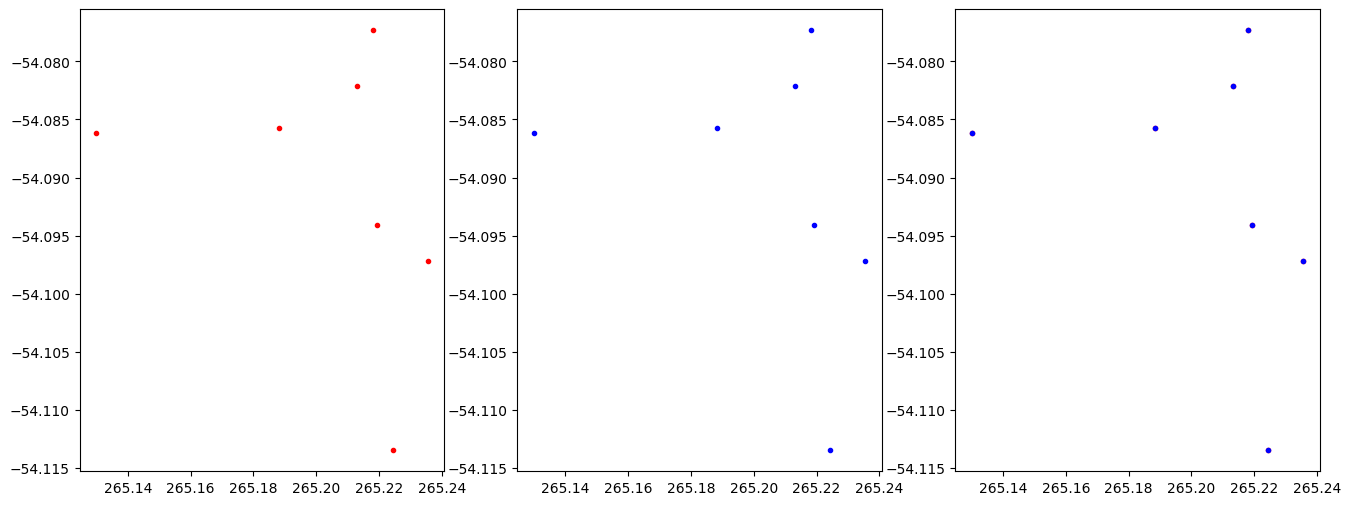

In [29]:
fig, axes = plt.subplots(1, 3, figsize= (16, 6))

axes[0].plot(match_radec[0], match_radec[1], '.', c='red')
axes[1].plot(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, '.', c='blue')

axes[2].plot(match_radec[0], match_radec[1], '.', c='red')
axes[2].plot(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, '.', c='blue')

### 更新底片模型

In [30]:
# 全体星应用
sext_out_x = sext_out_filter[:]["XWIN_IMAGE"]
sext_out_y = sext_out_filter[:]["YWIN_IMAGE"]
sext_out_mag = sext_out_filter[:][f"mag_{band}"]

sext_out_xieta = use_plate_model(sext_out_x - x_ref, sext_out_y - y_ref, A_CD, cof)
sext_out_radec = ideal_cel_coord(sext_out_xieta[0], sext_out_xieta[1], pointing_ra, pointing_dec)

sext_out_ra = sext_out_radec[0]
sext_out_dec = sext_out_radec[1]

# 全体再次匹配
refcat_lib_all = pd.DataFrame({"RA_ICRS": refcat_ra_now, "DE_ICRS": refcat_dec_now})
side_threshold = 0.00001
match_res_all = []

for i in range(len(sext_out_ra)):
    temp_lib = np.array([sext_out_ra[i], sext_out_dec[i]])
    index = np.sum(np.abs(refcat_lib_all - temp_lib) < side_threshold, axis=1) ==2
    if np.sum(index) == 1:
        match_res_all.append(np.hstack((np.array(temp_lib), int(i), np.array(refcat_lib_all[index].loc[:, :"DE_ICRS"])[0])))

match_res_all = np.array(match_res_all)

# 更新底片模型及
match_res_xi_gaia_all, match_res_eta_gaia_all = cel_ideal_coord(match_res_all[:, 0], match_res_all[:, 1], pointing_ra, pointing_dec)
Y_xi = match_res_xi_gaia_all / (np.pi / 180)
Y_eta = match_res_eta_gaia_all / (np.pi / 180)

match_res_x_sext_all = np.zeros_like(match_res_xi_gaia_all)
match_res_y_sext_all = np.zeros_like(match_res_xi_gaia_all)
match_res_mag_sext_all = np.zeros_like(match_res_xi_gaia_all)
for index, i in enumerate(match_res_all[:, 2]):
    match_res_x_sext_all[index] = sext_out_x[int(i)]
    match_res_y_sext_all[index] = sext_out_y[int(i)]
    match_res_mag_sext_all[index] = sext_out_mag[int(i)]

match_x = match_res_x_sext_all
match_y = match_res_y_sext_all
match_mag = match_res_mag_sext_all
print("the matched stars", len(match_x))

cof = int(np.floor((np.sqrt(8 * len(match_x) + 1) - 3) / 2))
cof = 4
A_CD = cal_plate_model(match_x - x_ref, match_y - y_ref, Y_xi, Y_eta, cof)

print(A_CD)

# 再应用底片模型
match_xieta = use_plate_model(match_x - x_ref, match_y - y_ref, A_CD, cof)
match_radec = ideal_cel_coord(match_xieta[0], match_xieta[1], pointing_ra, pointing_dec)
gaia_radec = (match_res_all[:, 3], match_res_all[:, 4])
gaia_xieta = cel_ideal_coord(gaia_radec[0], gaia_radec[1], pointing_ra, pointing_dec)


# 残差
dis_xi = (match_xieta[0] - gaia_xieta[0])
dis_eta = (match_xieta[1] - gaia_xieta[1])
dis_ra = (match_radec[0] - match_res_all[:, 3]) * 3600000
dis_dec = (match_radec[1] - match_res_all[:, 4]) * 3600000

# # plt.plot(match_x, match_y, '.')

the matched stars 83
[[-3.77603112e-05  1.38986689e-05 -3.15852806e-08 -1.54201406e-13
   3.41471560e-11  8.24437090e-13 -4.04938080e-24 -9.41095661e-23
   4.30957868e-24 -4.93809256e-24 -1.35671750e-28  5.62655041e-28
  -9.43872073e-27  2.08498402e-27  1.06969539e-27]
 [ 4.63695480e-06  1.35098048e-08 -1.39088455e-05 -1.43196937e-11
   7.22514211e-12 -3.65570298e-11 -4.52596638e-24 -6.37890346e-23
   1.37809583e-23 -7.14493410e-25  1.89696396e-29 -9.02506179e-28
  -1.02019437e-26 -1.59744333e-29  3.52177090e-28]]


### 残差图

In [18]:
# create bins
bins_num = 2
bins_x = np.linspace(0.5, 9216.5, bins_num + 1)
bins_y = np.linspace(0.5, 9232.5, bins_num + 1)

# bins' centers of all box
bin_centers_x = (bins_x[:-1] + bins_x[1:]) / 2
bin_centers_y = (bins_y[:-1] + bins_y[1:]) / 2
bin_centers = np.transpose([np.tile(bin_centers_x, len(bin_centers_y)), np.repeat(bin_centers_y, len(bin_centers_x))])

# calculate error
distort_sum_bins = np.zeros((bins_num, bins_num))
distort_sum_values_x = np.zeros((bins_num, bins_num))
distort_sum_values_y = np.zeros((bins_num, bins_num))

In [19]:
dis_res_xy = [np.vstack((match_x, match_y, dis_xi, dis_eta))]
[distort_sum_bins, distort_sum_values_x, distort_sum_values_y] = cal_distort_model(dis_res_xy, bins_x, bins_y, bins_num, distort_sum_bins, distort_sum_values_x, distort_sum_values_y)

distort_mean_values_x = np.divide(distort_sum_values_x, distort_sum_bins, out=np.zeros_like(distort_sum_values_x), where=distort_sum_bins != 0)
distort_mean_values_y = np.divide(distort_sum_values_y, distort_sum_bins, out=np.zeros_like(distort_sum_values_y), where=distort_sum_bins != 0)

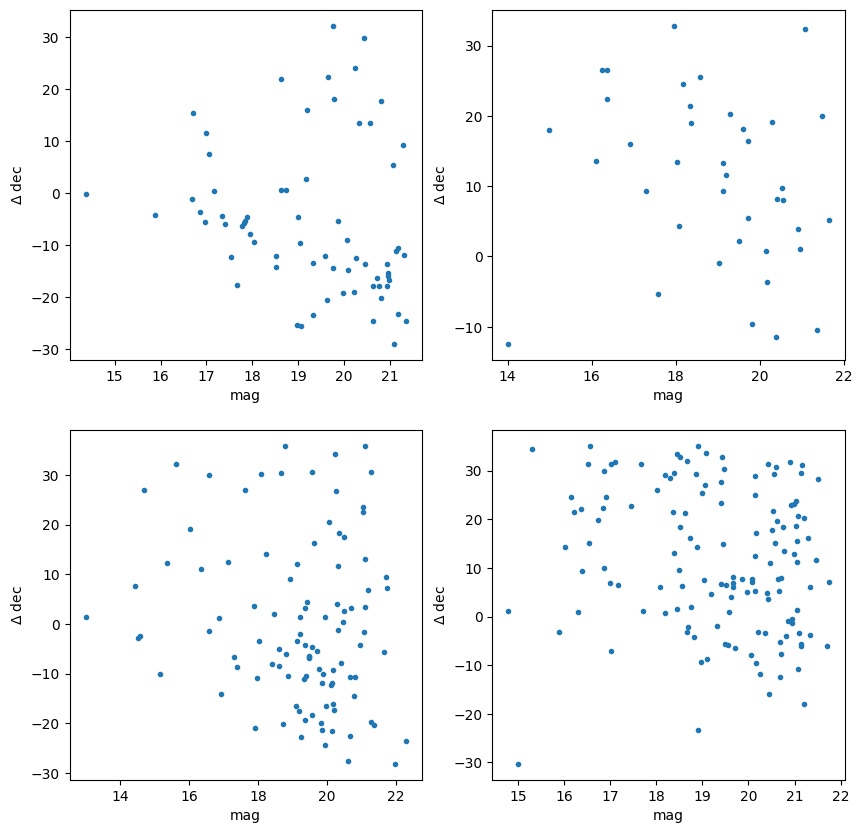

In [20]:
# mag-distortion
bins_x_id, bins_y_id = match_box_id(match_x, match_y, bins_x, bins_y)

dict_mag_dis = {}
fig, axes = plt.subplots(bins_num, bins_num, figsize= (bins_num * 5, bins_num * 5))

for i in range(0, bins_num):
    for j in range(0, bins_num):
        dict_mag_dis.update({str(i)+str(j): []})
        index = (bins_x_id == i) & (bins_y_id == j)
        match_mag_box = match_mag[index]
        match_x_box = match_x[index]
        match_y_box = match_y[index]
        dis_eta_box = dis_dec[index]
        axes[i][j].plot(match_mag_box, dis_eta_box, '.')
        axes[i][j].set_xlabel("mag")
        axes[i][j].set_ylabel(r"$\Delta$ dec")

        bins_num_mag_box = 8
        bins_mag_box = np.linspace(np.min(match_mag_box) * 0.99, max(match_mag_box) * 1.01, bins_num_mag_box + 1)
        bin_centers_mag_box = (bins_mag_box[:-1] + bins_mag_box[1:]) / 2
        dict_mag_dis[str(i)+str(j)].append(bin_centers_mag_box)

        bins_mag_box_dis_eta = []
        bins_mag_box_id = np.digitize(match_mag_box, bins_mag_box) - 1
        for k in range(0, bins_num_mag_box):
            index_mag = bins_mag_box_id == k
            bins_mag_box_dis_eta.append(np.std(dis_eta_box[index_mag]))
        dict_mag_dis[str(i)+str(j)].append(bins_mag_box_dis_eta)
            


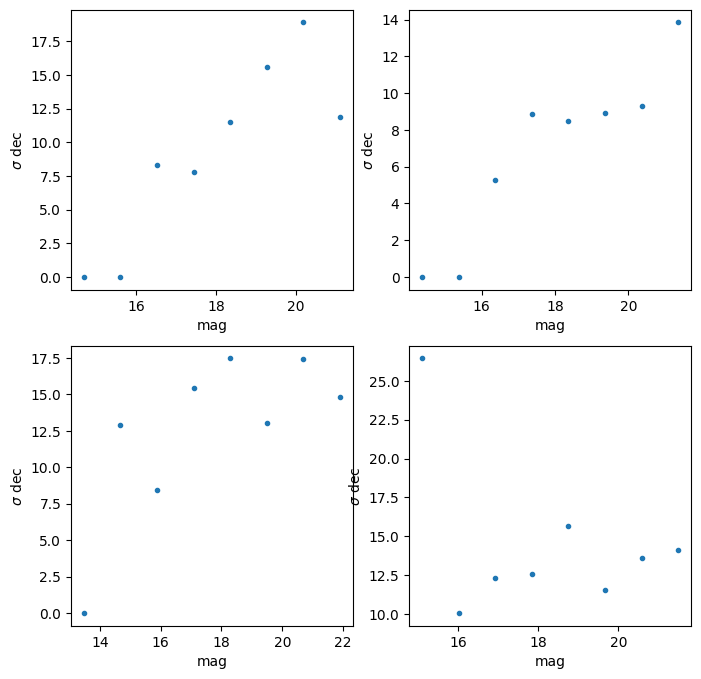

In [21]:
fig, axes = plt.subplots(bins_num, bins_num, figsize= (bins_num * 4, bins_num * 4))

for i in range(0, bins_num):
    for j in range(0, bins_num):
        axes[i][j].plot(dict_mag_dis[str(i)+str(j)][0], dict_mag_dis[str(i)+str(j)][1], '.')
        axes[i][j].set_xlabel("mag")
        axes[i][j].set_ylabel(r"$\sigma$ dec")


In [22]:
dict_mag_dis

{'00': [array([14.6808969 , 15.59818099, 16.51546508, 17.43274917, 18.35003326,
         19.26731735, 20.18460144, 21.10188553]),
  [0.0,
   0.0,
   8.339356906084667,
   7.777033652162567,
   11.492862661084258,
   15.586666318732302,
   18.899032697699973,
   11.900130132062406]],
 '01': [array([14.37207483, 15.3699796 , 16.36788437, 17.36578915, 18.36369391,
         19.36159868, 20.35950345, 21.35740823]),
  [0.0,
   0.0,
   5.276723398097752,
   8.890529855977604,
   8.50037614158008,
   8.89413870372528,
   9.291135132912592,
   13.843418306909273]],
 '10': [array([13.47442295, 14.67792484, 15.88142672, 17.0849286 , 18.28843049,
         19.49193237, 20.69543425, 21.89893614]),
  [0.0,
   12.888597351362362,
   8.423445141285445,
   15.420543406878917,
   17.459296820457045,
   13.025772194060297,
   17.44062126255125,
   14.788521690343034]],
 '11': [array([15.09331457, 16.00818404, 16.92305351, 17.83792298, 18.75279246,
         19.66766193, 20.5825314 , 21.49740087]),
  [26.43

In [23]:
# dict_mag_dis["21"]

# x = dict_mag_dis["21"][0]
# y = dict_mag_dis["21"][1]

# X = np.array([np.ones_like(x), x]).T
# Y = y
# A = np.linalg.inv(X.T @ X) @ X.T @ Y

# plt.plot(dict_mag_dis["21"][0], dict_mag_dis["21"][1], '.')
# plt.plot(dict_mag_dis["21"][0], dict_mag_dis["21"][0] * A[1] + A[0], '.')

### test

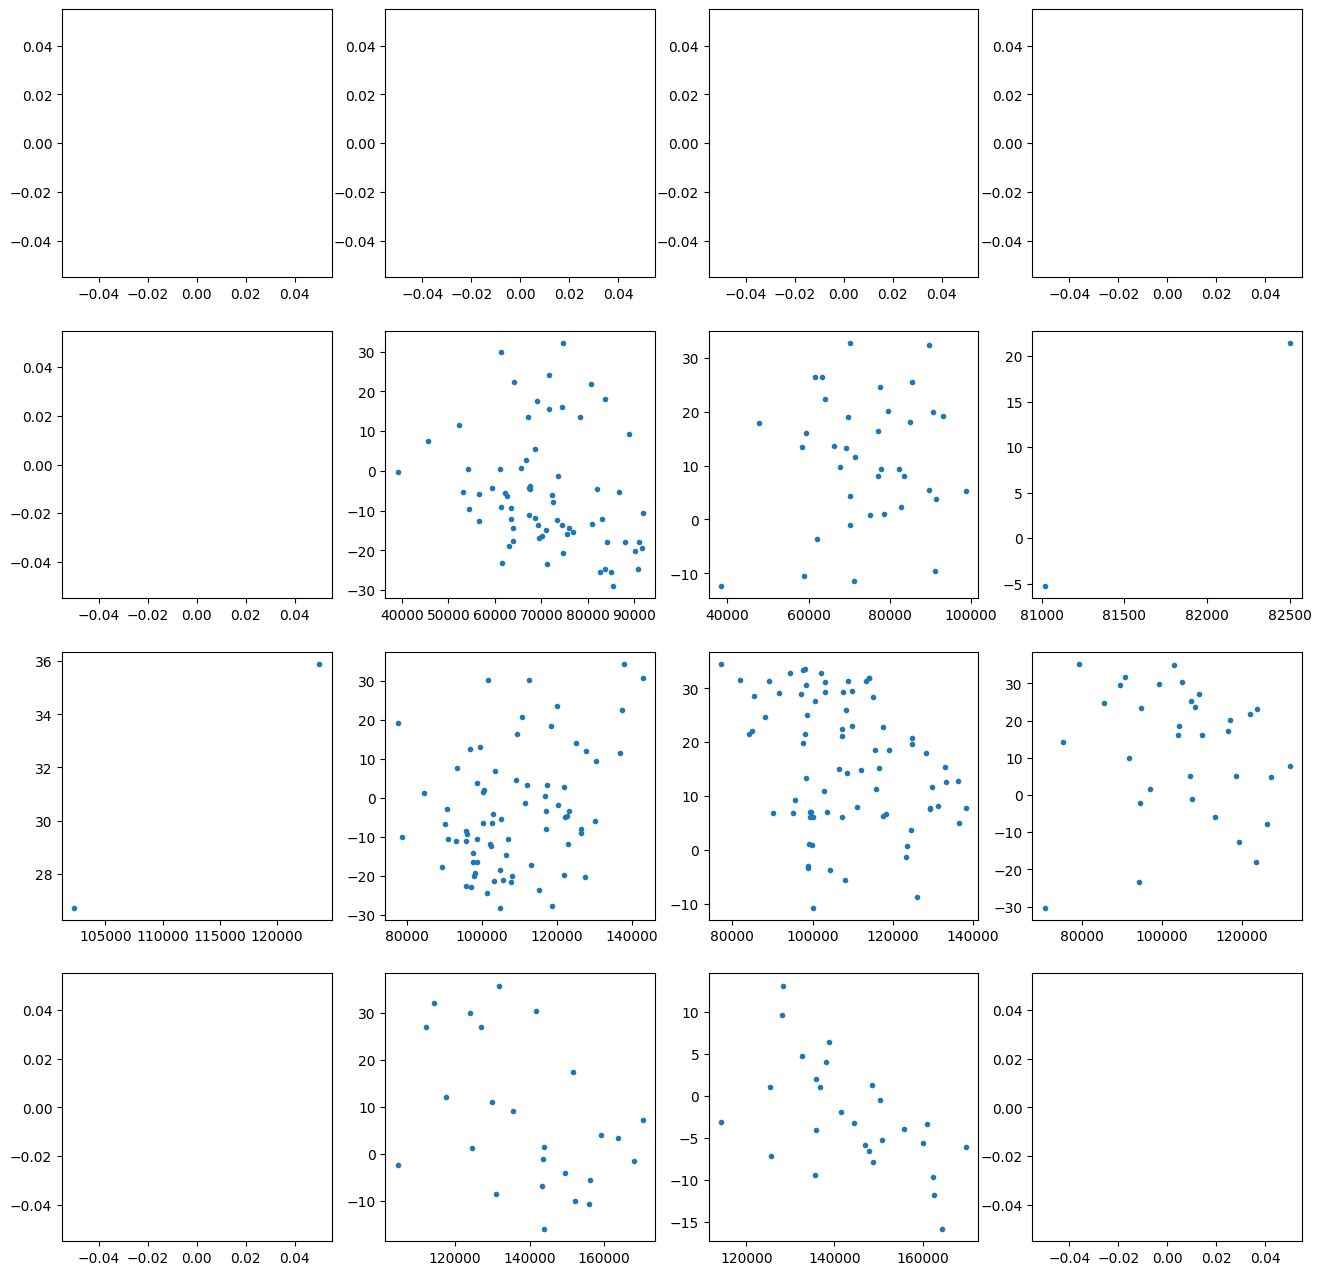

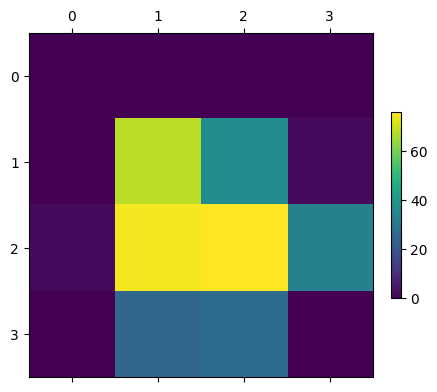

In [24]:
# create bins
bins_num = 4
bins_x = np.linspace(0.5, 9216.5, bins_num + 1)
bins_y = np.linspace(0.5, 9232.5, bins_num + 1)

# bins' centers of all box
bin_centers_x = (bins_x[:-1] + bins_x[1:]) / 2
bin_centers_y = (bins_y[:-1] + bins_y[1:]) / 2
bin_centers = np.transpose([np.tile(bin_centers_x, len(bin_centers_y)), np.repeat(bin_centers_y, len(bin_centers_x))])

# calculate distortion error model
distort_sum_bins = np.zeros((bins_num, bins_num))
distort_sum_values_x = np.zeros((bins_num, bins_num))
distort_sum_values_y = np.zeros((bins_num, bins_num))

dis_res_xy = [np.vstack((match_x, match_y, dis_ra, dis_dec))]
[distort_sum_bins, distort_sum_values_x, distort_sum_values_y] = cal_distort_model(dis_res_xy, bins_x, bins_y, bins_num, distort_sum_bins, distort_sum_values_x, distort_sum_values_y)

distort_mean_values_x = np.divide(distort_sum_values_x, distort_sum_bins, out=np.zeros_like(distort_sum_values_x), where=distort_sum_bins != 0)
distort_mean_values_y = np.divide(distort_sum_values_y, distort_sum_bins, out=np.zeros_like(distort_sum_values_y), where=distort_sum_bins != 0)

# mag-distortion
bins_x_id, bins_y_id = match_box_id(match_x, match_y, bins_x, bins_y)

fig, axes = plt.subplots(bins_num, bins_num, figsize= (bins_num * 4, bins_num * 4))

for i in range(0, bins_num):
    for j in range(0, bins_num):
        index = (bins_x_id == i) & (bins_y_id == j)
        axes[i][j].plot(match_mag[index] * match_x[index], dis_dec[index], '.')

ax = plt.matshow(distort_sum_bins)
plt.colorbar(ax.colorbar, fraction=0.025)

In [25]:
# fig, axes = plt.subplots(1, 2)
# axes[0].quiver(bin_centers[:, 0], bin_centers[:, 1], distort_mean_values_x.flatten(), distort_mean_values_y.flatten(), scale=1500)

# axes[1].matshow(distort_mean_values_x)

# ax = plt.matshow(distort_mean_values_x)
# plt.colorbar(ax.colorbar, fraction=0.025)
# plt.title("matrix X");
# plt.show()